In [25]:
import os
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn_image as isns

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint

In [26]:
tf.version.VERSION

'2.8.4'

In [27]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Preparation
We just load the data and reshape into 28 by 28 images.

In [28]:
train_data_csv = pd.read_csv('data/train.csv')

In [29]:
train_featrues, train_targets = (train_data_csv.drop(['label'], axis=1), train_data_csv.label)

In [30]:
train_images = train_featrues.values.astype('float32').reshape(-1, 28, 28, 1)

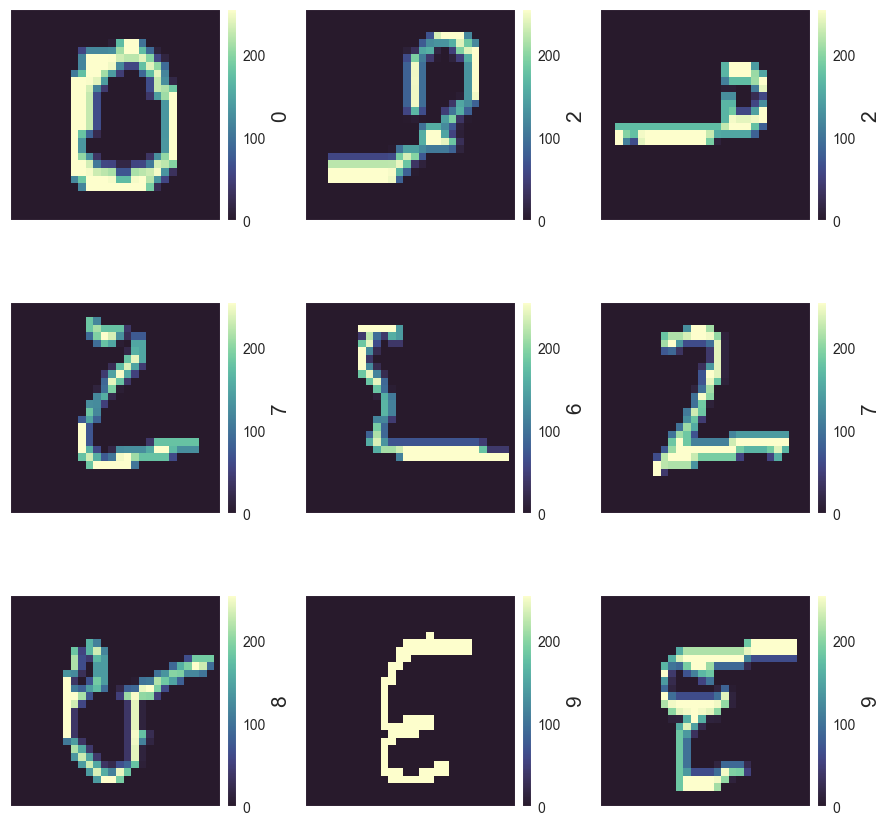

In [31]:
# check some samples
ints = np.random.randint(0, train_images.shape[0], 9)
_ = isns.ImageGrid([np.flipud(train_images[i, :, :, :].reshape(28, 28)) for i in ints],
                   cbar_label=[f'{train_targets[i]}' for i in ints],
                   col_wrap=3)

In [32]:
# convert targets to cat
train_targets = tf.keras.utils.to_categorical(train_targets, num_classes=10, dtype='float32')

In [33]:
train_targets.shape

(60000, 10)

In [34]:
train_images.shape

(60000, 28, 28, 1)

## 2. Experiments
Here I tried to select a good base model architecture. I experimented with fairly shallow CNNs mostly using different augemntation factors and various network related hyperparameters. What worked best was a shallow CNN with a wider receptive field that has multiple kernel sized blocks in the beginning with swish activateions (https://arxiv.org/pdf/1710.05941v1.pdf?source=post_page). The geometric augmentations are included via preprocessing layers for performance reasons (so they can be done on GPU in training time). "With this option, preprocessing will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration. If you're training on GPU, this is the best option for the Normalization layer, and for all image preprocessing and data augmentation layers." The experiments are saved along with the results.

Here, for the ML platform I use TensorFlow and for model building I use the Keras functional API (https://keras.io/guides/functional_api/). There are some syntactical and also functional differences to PyTorch (e.g. Theano vs Torch) , but the approaches are essentially the same.

In [35]:
# define geometric augments using preproc. layers
def scale_and_augment(input):
    x = Rescaling(1./255)(input)
    x = RandomRotation(.028, fill_mode='constant')(x)
    x = RandomTranslation(.25, .25, fill_mode='constant')(x)
    x = RandomZoom((-.2, .2), fill_mode='constant')(x)

    return x

# define a conv block for easy building
def conv_block(input, depth, kernel_size, num_kernels, activation, batchnorm):
    x = Conv2D(filters=num_kernels,
           kernel_size=kernel_size,
           padding='same',
           )(input)
    for _ in range(depth-1):
        x = Conv2D(filters=num_kernels,
                   kernel_size=kernel_size,
                   padding='same',
                   )(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)

    return x

In [36]:
# build some models..
def build_cnn_1(weights=None):
    name = 'cnn_1'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [37]:
def build_cnn_2(weights=None):
    name = 'cnn_2'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=16,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [38]:
def build_cnn_3(weights=None):
    """
    - starts with augmentation layers for the first regularizer
    - 3 input branches with different kernel sizes to capture different sized immediate image features
    - BatchNorm for second strong regularizer
    - Dropout for third regularizer
    - Swish, because it beats ReLU slightly: https://arxiv.org/pdf/1710.05941v1.pdf?source=post_page
    - Shallow: only 3 main conv layer blocks
        - we don't need complex features and colors etc
        - no need for transfer learning with 100+ layer imagenet CNN-s for the same reason
    - This has ~1M params, but even this many may be overkill

    :param weights:
    :return:
    """
    name = 'cnn_3'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x1 = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='swish',
                   batchnorm=True)

    x2 = conv_block(input=x,
               depth=2,
               kernel_size=5,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x2 = conv_block(input=x2,
               depth=2,
               kernel_size=3,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x3 = conv_block(input=x,
               depth=1,
               kernel_size=7,
               num_kernels=32,
               activation='swish',
               batchnorm=True)


    x = Concatenate()([x1, x2, x3])

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='swish')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model, name

In [39]:
model, name = build_cnn_3()

In [40]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 28, 28, 1)    0           ['input_3[0][0]']                
                                                                                                  
 random_rotation_2 (RandomRotat  (None, 28, 28, 1)   0           ['rescaling_2[0][0]']            
 ion)                                                                                             
                                                                                                  
 random_translation_2 (RandomTr  (None, 28, 28, 1)   0           ['random_rotation_2[0][0]']

In [41]:
# make a tf Dataset
ds_train_set = tf.data.Dataset.from_tensor_slices((train_images, train_targets))

In [42]:
# split and batch
SPLIT = .1
BATCH_SIZE = 2048

ds_eval = ds_train_set.take(round(train_targets.shape[0]*SPLIT))
ds_train = ds_train_set.skip(round(train_targets.shape[0]*SPLIT))

ds_train = ds_train.batch(BATCH_SIZE)
ds_eval = ds_eval.batch(BATCH_SIZE)

In [43]:
# speed
AUTOTUNE = tf.data.AUTOTUNE

In [44]:
ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

In [21]:
history = model.fit(
                    ds_train,
                    validation_data=ds_eval,
                    epochs=100,
                    callbacks=[ModelCheckpoint(f'./models/{name}/weights_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)]
                    )

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.7307
Epoch 1: val_accuracy improved from -inf to 0.10350, saving model to ./models/cnn_3\weights_best.h5
27/27 [==============================] - 16s 281ms/step - loss: 0.8376 - accuracy: 0.7307 - val_loss: 2.3274 - val_accuracy: 0.1035
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9471
Epoch 2: val_accuracy improved from 0.10350 to 0.12433, saving model to ./models/cnn_3\weights_best.h5
27/27 [==============================] - 6s 215ms/step - loss: 0.1600 - accuracy: 0.9471 - val_loss: 3.5572 - val_accuracy: 0.1243
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9617
Epoch 3: val_accuracy improved from 0.12433 to 0.21267, saving model to ./models/cnn_3\weights_best.h5
27/27 [==============================] - 6s 216ms/step - loss: 0.1175 - accuracy: 0.9617 - val_loss: 3.8301 - val_accuracy: 0.2127
Epoch 4/100
27/

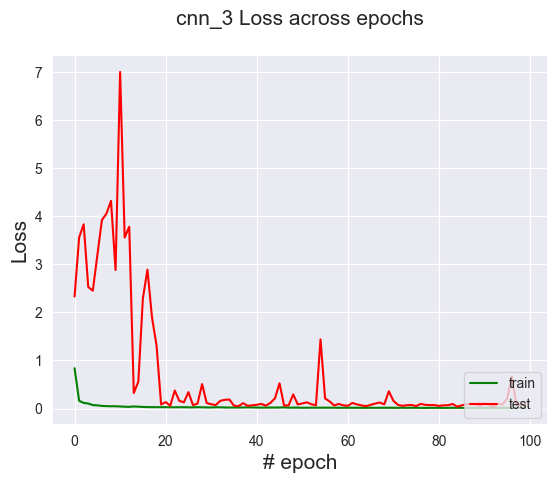

In [22]:
# plot hist
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.title(f'{name} Loss across epochs\n')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')

In [ ]:
# save the experiment
model.load_weights(f'./models/{name}/weights_best.h5')

scores = model.evaluate(ds_eval)

os.makedirs(f'./models/{name}/model', exist_ok=True)
model.save(filepath=f'./models/{name}/model', save_format='tf')

print("done training!")

original_stdout = sys.stdout
with open(f'./models/{name}/training.info', 'w') as f:
    sys.stdout = f

    print(f'\n\n***MODEL SUMMARY***\nacc: {scores[2]}')
    print(model.summary())
    print('\n\n****FLOPS***\n')

    sys.stdout = original_stdout

print('done experiment!')

3/3 [==============================] - 1s 65ms/step - loss: 0.0398 - accuracy: 0.9925
INFO:tensorflow:Assets written to: ./models/cnn_3/model\assets
done training!


## 3. Ensemble + Pseudo Labelling
Since we have an already very accurate classifier, we may use some semi supervised learning to improve the score further. With pseudo labeling we predict on the test set and use confidently predicted test samples to extend our training data. We then train multiple models and use the average PD to make the final predictions.

![](Pseudo-Labeling-Learning-Architecture.png)

In [45]:
# training loop for ensemble
def train_n_models(n, dataset, prefix, split, epochs):
    for i in range(n):
        ds = dataset.shuffle(len(dataset), reshuffle_each_iteration=False)

        SPLIT = split
        BATCH_SIZE = 2048

        ds_eval = ds.take(round(train_targets.shape[0] * SPLIT))
        ds_train = ds.skip(round(train_targets.shape[0] * SPLIT))

        ds_train = ds_train.batch(BATCH_SIZE)
        ds_eval = ds_eval.batch(8)

        ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

        model, _ = build_cnn_3()

        history = model.fit(
            ds_train,
            validation_data=ds_eval,
            epochs=epochs,
            callbacks=[
                ModelCheckpoint(f'./models/{prefix}/weights_best_{i}.h5', monitor='val_accuracy', save_best_only=True, mode='max',
                                verbose=1)]
        )

        model.load_weights(f'./models/{prefix}/weights_best_{i}.h5')

        os.makedirs(f'./models/{prefix}/{i}/model', exist_ok=True)
        model.save(filepath=f'./models/{prefix}/{i}/model', save_format='tf')

In [46]:
# load and transform test data
test_data_csv = pd.read_csv('data/test.csv')
ids, test_images = test_data_csv.id, test_data_csv.drop(['id'], axis=1).values.astype('float32').reshape(-1, 28, 28, 1)

In [47]:
# load trained base model
model, _ = build_cnn_3(f'./models/cnn_3/weights_best.h5')

In [48]:
test_images.shape

(5000, 28, 28, 1)

In [49]:
# predict on test set
preds = model.predict(test_images)

In [50]:
# get test labels
test_targets = np.argmax(preds, axis=1)

# get indices with high confidence
ids_confident = np.argwhere((preds > .95).any(axis=1))

# select from the preds
test_images_confident, test_targets_confident = (test_images[ids_confident].astype('float32'), np.squeeze(test_targets[ids_confident]))
test_images_confident = test_images_confident.reshape(-1, 28, 28, 1)

In [51]:
test_images_confident.shape

(4838, 28, 28, 1)

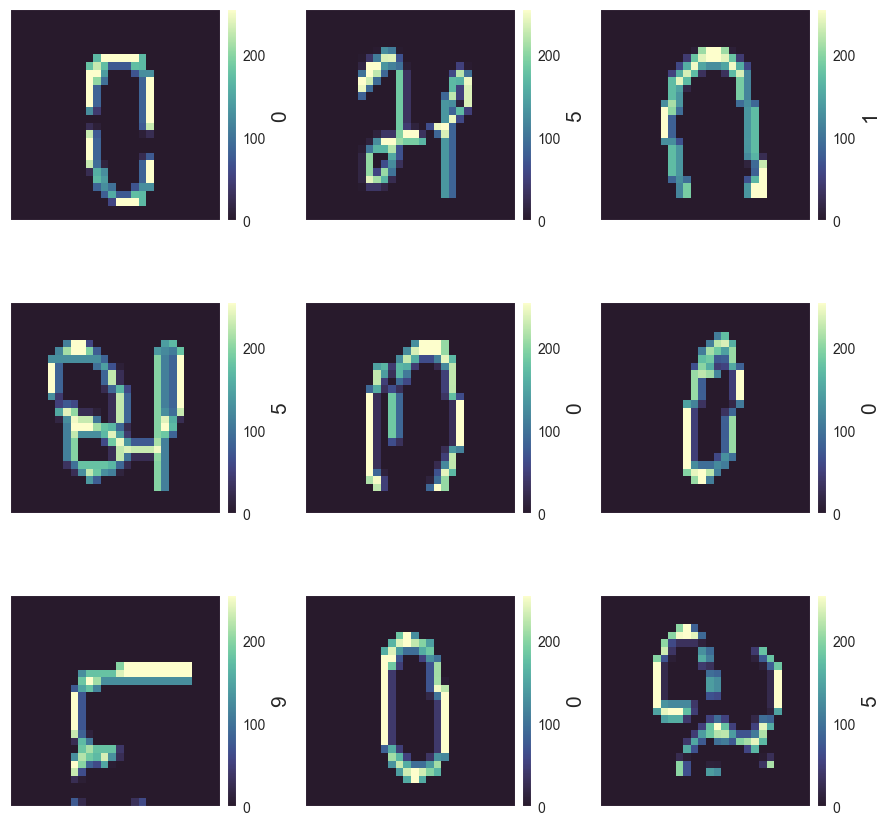

In [52]:
# check some predictions
ints = np.random.randint(0, test_images_confident.shape[0], 9)
_ = isns.ImageGrid([np.flipud(test_images_confident[i, :, :, :].reshape(28, 28)) for i in ints],
                   cbar_label=[f'{test_targets_confident[i]}' for i in ints],
                   col_wrap=3)

In [53]:
# convert tets targets to cat
test_targets_confident = tf.keras.utils.to_categorical(test_targets_confident, num_classes=10, dtype='float32')

In [54]:
# create test ds and combine with train ds to get pseudo ds
ds_test_confident = tf.data.Dataset.from_tensor_slices((test_images_confident, test_targets_confident))
ds_pseudo_label = ds_train_set.concatenate(ds_test_confident)

In [55]:
len(ds_pseudo_label)

64838

In [ ]:
# train 3 models
train_n_models(n=3,
               dataset=ds_pseudo_label,
               prefix='pseudo_label',
               split=.015,
               epochs=100)

In [57]:
# create ensemble preds
preds_ensemble = []
for i in range(3):
    model = keras.models.load_model(
        f'./models/pseudo_label_v2/{i}/model')
    preds = model.predict(test_images)

    preds_ensemble.append(preds.reshape(-1, 10, 1))

In [58]:
preds_ensemble_arr = np.concatenate(preds_ensemble, axis=2)
preds_ensemble_final = np.argmax(np.mean(preds_ensemble_arr, axis=2), axis=1)

In [59]:
# this reached 0.9842 private and 0.9848 public score
preds_ensemble_final

array([3, 0, 2, ..., 1, 6, 3], dtype=int64)

From here it's more experimenting, but I ran out of time to tune this..

In [66]:
def train_n_models_v2(n, images_ds, targets_ds, prefix, splits, epochs):
    for i in range(n):
        train_images = images_ds[i]
        train_targets = targets_ds[i]

        ds = tf.data.Dataset.from_tensor_slices((train_images, train_targets))

        BATCH_SIZE = 2048

        ds_eval = ds.take(round(train_targets.shape[0] * splits[i]))
        ds_train = ds.skip(round(train_targets.shape[0] * splits[i]))

        ds_train = ds_train.batch(BATCH_SIZE)
        ds_eval = ds_eval.batch(8)

        ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

        model, _ = build_cnn_3()


        if splits[i] == 0:
            print(f"fitting model {i} with no callbacks..")

            history = model.fit(
            ds_train,
            epochs=epochs[i])

        else:
            print(f"fitting model {i} WITH callbacks..")

            history = model.fit(
            ds_train,
            validation_data=ds_eval,
            epochs=epochs[i],
            callbacks=[
                ModelCheckpoint(f'./models/{prefix}/weights_best_{i}.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)])

        if splits[i] != 0:
            model.load_weights(f'./models/{prefix}/weights_best_{i}.h5')

        os.makedirs(f'./models/{prefix}/{i}/model', exist_ok=True)
        model.save(filepath=f'./models/{prefix}/{i}/model', save_format='tf')

In [ ]:
# making datasets using pseudo labeling based on previous preds
images_pseudo_ds = []
targets_pseudo_ds = []
for i in range(4):
    model, _ = build_cnn_3(f'./models/final_models/weights_best_{i}.h5')

    preds = model.predict(test_images)

    test_targets = np.argmax(preds, axis=1)

    ids_confident = np.argwhere((preds > .95).any(axis=1))

    test_images_confident, test_targets_confident = (test_images[ids_confident].astype('float32'), np.squeeze(test_targets[ids_confident]))
    test_images_confident = test_images_confident.reshape(-1, 28, 28, 1)

    test_targets_confident = tf.keras.utils.to_categorical(test_targets_confident, num_classes=10, dtype='float32')

    images_pseudo = np.concatenate([train_images, test_images_confident], axis=0)
    targets_pseudo = np.concatenate([train_targets, test_targets_confident], axis=0)

    rand_order = np.array(range(targets_pseudo.shape[0]))
    np.random.shuffle(rand_order)

    images_pseudo = images_pseudo[rand_order]
    targets_pseudo = targets_pseudo[rand_order]

    print(images_pseudo.shape, targets_pseudo.shape)

    images_pseudo_ds.append(images_pseudo)
    targets_pseudo_ds.append(targets_pseudo)

train_n_models_v2(n=4,
                   images_ds=images_pseudo_ds,
                   targets_ds=targets_pseudo_ds,
                   prefix='pseudo_label_v2',
                   splits=[.1, .05, .01,  0.005],
                   epochs=[100, 100, 100, 100])

In [ ]:
preds_ensemble = []
for i in range(4):
    model = keras.models.load_model(f'C:/KBData/01_PROJECT/00_GIT/ELTE/data_mining/comp_3/models/pseudo_label_v2/{i}/model')
    preds = model.predict(test_images)

    preds_ensemble.append(preds.reshape(-1, 10, 1))

In [69]:
preds_ensemble[0].shape

(5000, 10, 1)

In [70]:
preds_ensemble_arr = np.concatenate(preds_ensemble, axis=2)

In [71]:
preds_ensemble_final = np.argmax(np.mean(preds_ensemble_arr, axis=2), axis=1)

In [72]:
preds_ensemble_final

array([3, 0, 2, ..., 1, 6, 3], dtype=int64)